# Tasks
This notebook is for conducting an analysis, no finite plots will be constructed here.

# Uploads

In [1]:
# If you are a developer, you may want to reload the packages on a fly. 
# Jupyter has a magic for this particular purpose:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import cooler
import pyranges as pr
from statsmodels.stats.multitest import multipletests as fdr_correction
from sklearn.feature_selection import f_classif
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
 
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns

from glob import glob
import json
from os.path import basename, splitext
from importlib import reload
import gffpandas.gffpandas as gffpd
from natsort import natsorted

import utils
from utils.anova import *
from utils.gene_intervals import bins_to_genes_intersection
from utils.plot_functions import *
from utils.hic_preproc import *
reload(utils.anova)
reload(utils.plot_functions)
reload(utils.hic_preproc)

<module 'utils.hic_preproc' from '/home/dkriukov/mice/Aging_Brain_Mice/utils/hic_preproc.py'>

In [2]:
#crucial work dirs
COOLER_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC'
DOWNSAMPLED_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/downsampled'
INSULATION_PATH = '/tank/projects/kriukov_chromatin/HIC/insulation'
TAD_PATH = '/tank/projects/kriukov_chromatin/HIC/tads'
LOOP_PATH = '/tank/projects/kriukov_chromatin/HIC/loops'
COMPARTMENTS_PATH = '/tank/projects/kriukov_chromatin/HIC/compartments'
GENOME_FOLDER_PATH = '/tank/projects/kriukov_chromatin/GENOME'
ATAC_FOLDER_PATH = '/tank/projects/kriukov_chromatin/ATAC'

In [3]:
#import genes
gffpath = '%s/GCF_000001635.27_GRCm39_genomic.gff' % GENOME_FOLDER_PATH
annot_path = '%s/GCF_000001635.27_GRCm39_assembly_report.txt' % GENOME_FOLDER_PATH
#refseq to chrom annotation
annotation = gffpd.read_gff3(gffpath)
fasta_annot = pd.read_csv(annot_path, sep='\t', skiprows=28)
refseq2chrom = dict(zip(fasta_annot['RefSeq-Accn'].values, fasta_annot['UCSC-style-name'].values))
gn = annotation.attributes_to_columns()
gn.seq_id = gn.seq_id.map(refseq2chrom)
gn['length'] = gn['end'] - gn['start']
gn = gn[['seq_id', 'source', 'type', 'start', 'end', 'score', 'strand',
         'ID', 'Name', 'description', 'length', 'chromosome']]

#types of sequences
gn_code = gn[gn['type']=='gene'] #protein codeing
gn_lnc = gn[gn['type']=='lnc_RNA'] #long non-coding
gn_trna = gn[gn['type']=='tRNA'] #tRNA
gn_rrna = gn[gn['type']=='rRNA'] #rRNA

In [84]:
RESOLUTION = 50000
#FILES = natsorted(glob('%s/*.mcool' % COOLER_FOLDER_PATH))
#FILES = natsorted(glob('%s/*%s.cool' % (DOWNSAMPLED_FOLDER_PATH, RESOLUTION)))
FILES = natsorted(glob('%s/merged/*%s.cool' % (DOWNSAMPLED_FOLDER_PATH, RESOLUTION)))
#CLRS = [cooler.Cooler(p + "::/resolutions/%d" % RESOLUTION) for p in FILES]
CLRS = [cooler.Cooler(p) for p in FILES]

#insulation score
#IS = pd.read_csv('%s/IS_50000.csv' % INSULATION_PATH, index_col=0)
IS = pd.read_csv('%s/IS_merged_50000.csv' % INSULATION_PATH, index_col=0)

#consensus peaks
ATAC = pd.read_csv('%s/consensus_peaks.mLb.clN.boolean.annotatePeaks.txt' % ATAC_FOLDER_PATH, sep='\t')

#TADs
with open(TAD_PATH + '/' + 'lavaburst_tads_arkuda.json', 'r') as f:
    TADS = json.load(f)

# SCC

In [11]:
from hicrep.utils import readMcool
from hicrep import hicrepSCC
from itertools import combinations

binSize = 50000
h = 1            # smoothing window half-size
dBPMax = 8_000_000 # maximal genomic distance to include in the calculation

# whether to perform down-sampling or not 
# if set True, it will bootstrap the data set # with larger contact counts to
# the same number of contacts as in the other data set; otherwise, the contact 
# matrices will be normalized by the respective total number of contacts
bDownSample = False

paths = natsorted(glob(DOWNSAMPLED_FOLDER_PATH + '/*.cool'))
# compute the SCC score
# this will result in a SCC score for each chromosome available in the data set
N = len(paths)
scc_matrix = np.zeros([N, N])
for i in tqdm(range(N)):
    for j in range(i, N):
        cool1, _ = readMcool(paths[i], -1)
        cool2, _ = readMcool(paths[j], -1)
        scc = hicrepSCC(cool1, cool2, h, dBPMax, bDownSample)
        scc_matrix[i,j] = scc[:-1].mean()
        scc_matrix[j,i] = scc[:-1].mean()

  8%|▊         | 1/12 [01:28<16:09, 88.18s/it]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/hicrep/hicrep.py:91: RuntimeWarning: invalid value encountered in double_scalars
  return rhoNan2Zero @ wsNan2Zero / wsNan2Zero.sum()
100%|██████████| 12/12 [09:09<00:00, 45.82s/it]


In [26]:
#add names
np.fill_diagonal(scc_matrix, 1)
scc_df = pd.DataFrame(scc_matrix, 
                      columns=[basename(path).split('.')[0] for path in paths],
                      index=[basename(path).split('.')[0] for path in paths])

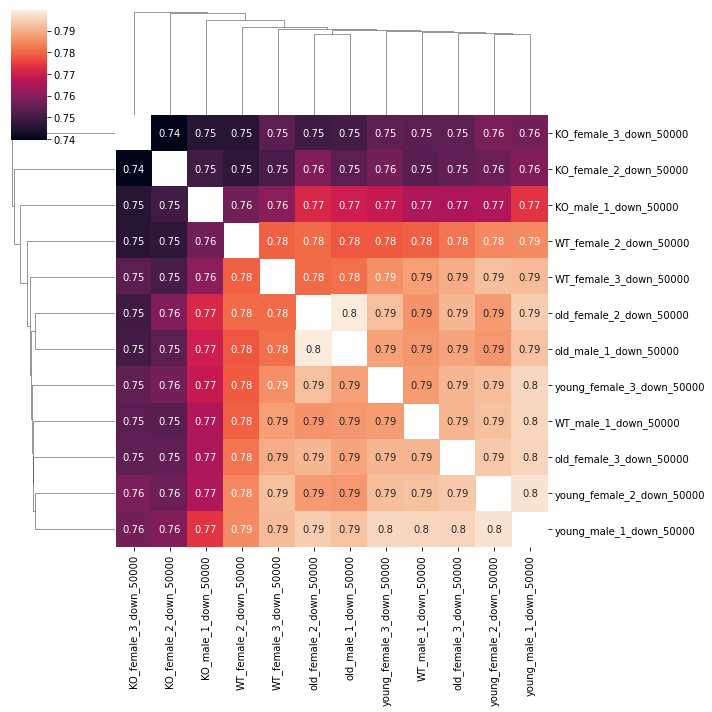

In [28]:
sns.clustermap(scc_df, annot=True , mask=scc_df==1)
#plt.savefig('./imgs/test.png', dpi=200)

# Insulation score analysis

## TAD shift analysis

In [132]:
from scipy.signal import argrelextrema
import scipy.optimize as optimization

explore = ['WT', 'young', 'old', 'KO']
mask = np.array([any([e in c for e in explore]) for c in IS.columns])

X = IS.drop(IS.columns[~mask], 1).T
#X = X.dropna(axis=1)

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


In [133]:
order = 5
indices = []
for i in range(X.shape[0]):
    row = X.iloc[i,:]
    s = np.array(row)
    lm = argrelextrema(s, np.less, order=order)[0]
    indices.append(row.iloc[lm].index)

result = sorted(list(set(indices[0]).intersection(*indices)))
border_dict = dict(zip(list(X.index), indices))

In [134]:
convex_dict = {}
for key in border_dict.keys():
    b = border_dict[key]
    convex_dict[key] = {}
    for i in range(b.shape[0]):
        x = np.arange(-order, order+1)
        v = X.loc[key, b[i]-order:b[i]+order] #vicinity of minimum
        y = v.to_numpy()

        def func(x, a):
            return a*(x**2) + y[y.shape[0]//2]

        params, _ = optimization.curve_fit(func, x, y)
        convex_dict[key][b[i]] = params.item()
    

# plt.scatter(x, y, marker='o', c='red')
# plt.plot(x, func(x, params), c='black')
# plt.show()

In [135]:
border_dict.keys()

dict_keys(['combined_KO_down_50000', 'combined_WT_down_50000', 'combined_old_down_50000', 'combined_young_down_50000'])

37449

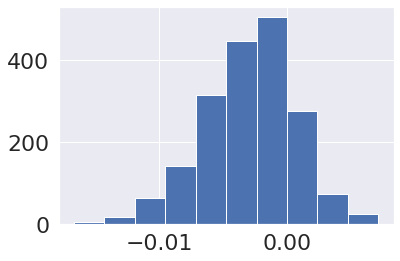

In [98]:
test = border_dict['combined_KO_down_50000'].intersection(border_dict['combined_WT_down_50000']).tolist()


diff = []
for t in test:
    d = convex_dict['combined_KO_down_50000'][t] - convex_dict['combined_WT_down_50000'][t]
    diff.append(d)

plt.hist(diff)
test[np.argmin(diff)]

In [99]:
pos = 105
st, fin = (pos-100, pos+100) # in bins

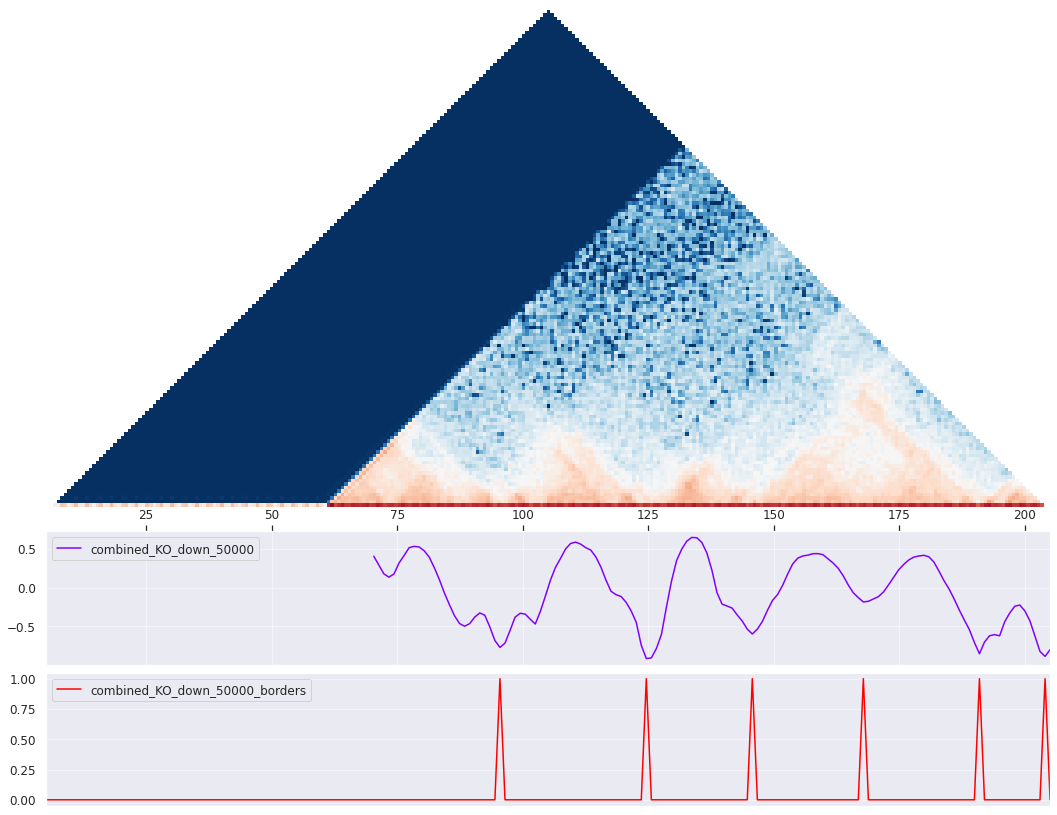

In [100]:
rep = 'combined_KO_down_50000'

assert len(IS.loc[st:fin].chrom.unique()) == 1, 'choose one chromosome interval'
chrom = IS.loc[st:fin].chrom.unique()[0]

#HI-C
cool = [c for c in CLRS if c.filename.__contains__(rep)][0]
D = cool.matrix(balance=True).fetch(chrom)
D = mylog(D, log=True)
bins = cool.bins()[:]
start = bins[bins.chrom==chrom].index[0]
#IS
profile = np.array(IS[rep])#.loc[st:fin-1])
#TAD BORDERS
borders_plot = np.zeros(profile.shape)
for idx in border_dict[rep]:
    borders_plot[idx] += 1

plot_hic(D, st, fin, profile=[profile, borders_plot], 
                         profnames=[rep, rep + '_borders'], chrom_start=start)

In [15]:
# rep = 'young_male_1'

# assert len(IS.loc[st:fin].chrom.unique()) == 1, 'choose one chromosome interval'
# chrom = IS.loc[st:fin].chrom.unique()[0]

# #HI-C
# cool = [c for c in CLRS if c.filename.__contains__(rep)][0]
# D = cool.matrix(balance=True).fetch(chrom)
# D = mylog(D, log=True)
# bins = cool.bins()[:]
# start = bins[bins.chrom==chrom].index[0]
# #IS
# profile = np.array(IS[rep])#.loc[st:fin-1])
# #TAD BORDERS
# borders_plot = np.zeros(profile.shape)
# for idx in border_dict[rep]:
#     borders_plot[idx] += 1

# plot_hic(D, st, fin, profile=[profile, borders_plot], 
#                          profnames=[rep, rep + '_borders'], chrom_start=start)

## insulation peaks fold change

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

KO v.s. WT: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.040e-04 U_stat=6.462e+06
old v.s. young: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.111e+06
WT v.s. young: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.029e+06
KO v.s. old: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.092e-03 U_stat=6.379e+06


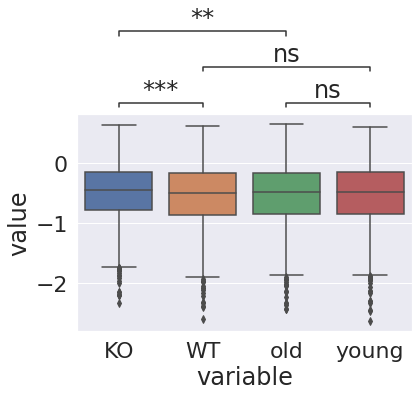

In [184]:
from functools import reduce
union = reduce(pd.Index.union, border_dict.values())

bpeaks = IS.loc[union]
tmp = pd.melt(bpeaks.iloc[:, 1:5])
tmp['variable'] = tmp['variable'].apply(lambda x: x.split('_')[1])
#for pair in 
#d = bpeaks.filter(regex='KO').iloc[:, 0] - bpeaks.filter(regex='WT').iloc[:, 0]
#d.plot(kind='kde')

from statannot import add_stat_annotation

df = sns.load_dataset("tips")
x = "variable"
y = "value"
order = ['KO', 'WT', 'old', 'young']
ax = sns.boxplot(data=tmp, x=x, y=y, order=order)
test_results = add_stat_annotation(ax, data=tmp, x=x, y=y, order=order,
                                   box_pairs=[("KO", "WT"), ("old", "young"), ("WT", "young"), ("KO", "old")],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=2)

## interTADs

In [5]:
#coolpuppy API
# import libraries for biological data analysis
from coolpuppy import coolpup
from plotpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis
from cooltools.lib import plotting
import logging
logging.getLogger().disabled = True
sns.set_theme(font_scale=2)

# Use bioframe to fetch the genomic features from the UCSC.
mm10_chromsizes = bioframe.fetch_chromsizes('mm10')
mm10_cens = bioframe.fetch_centromeres('mm10')
mm10_arms = bioframe.make_chromarms(mm10_chromsizes, mm10_cens)

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
mm10_arms = mm10_arms.set_index("chrom").loc[CLRS[0].chromnames].reset_index()
# call this to automaticly assign names to chromosomal arms:
mm10_arms = bioframe.make_viewframe(mm10_arms)

In [23]:
mm10_arms = bioframe.make_chromarms(mm10_chromsizes, mm10_cens)
mm10_arms = mm10_arms.set_index("chrom")

In [24]:
mm10_chromsizes.to_csv('/tank/projects/kriukov_chromatin/GENOME/chrfile.txt', sep='\t')
mm10_arms.to_csv('/tank/projects/kriukov_chromatin/GENOME/chrom_arms.txt', sep='\t')

In [107]:
#construct average interTADs
pup = pd.DataFrame()
cond = [basename(c.filename).split('_')[1] for c in CLRS]
for k, v in border_dict.items():
    clr = [c for c in CLRS if c.filename.__contains__(k)][0]
    name = splitext(basename(clr.filename))[0]
    sites = IS.loc[v.tolist(),['chrom', 'start', 'end']].reset_index(drop=True)
    # Calculate expected interactions for chromosome arms
    expected = expected_cis(clr, view_df=mm10_arms, chunksize=1000000, nproc=18)
    #calculate mean interTADs
    cc = coolpup.CoordCreator(sites, resolution=RESOLUTION, 
                              features_format='bed', local=True, flank=1_000_000)
    pu = coolpup.PileUpper(clr, cc, expected=expected, view_df=mm10_arms, ignore_diags=0)
    pup = pup.append(pu.pileupsWithControl(nproc=18))
pup['condition'] = cond
#pup['id'] = [basename(c.filename).split('_')[1] + '_' + basename(c.filename).split('_')[2].split('.')[0] for c in CLRS]

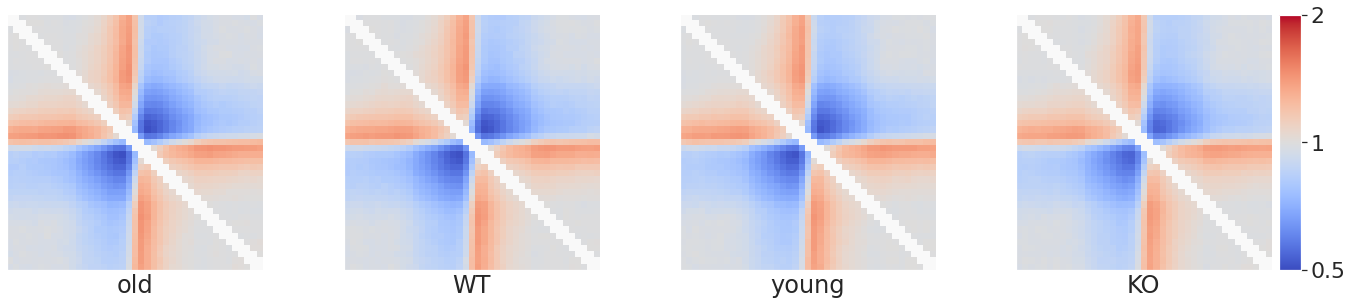

In [114]:
plotpup.make_heatmap_grid(pup,
                          #rows='condition', #col_order=['--', '++'],
                          cols='condition',
                          score=False, cmap='coolwarm', scale='log',
                          sym=True, vmax=2,
                          height=5)

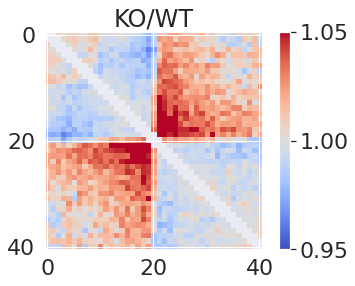

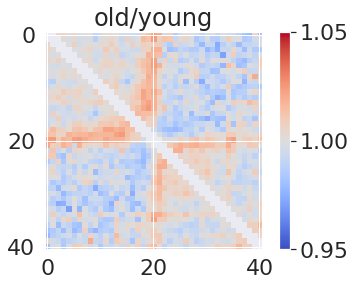

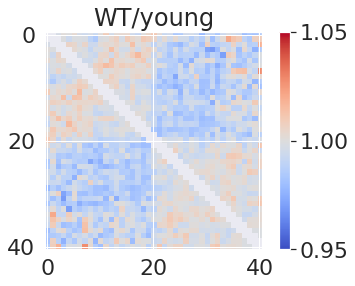

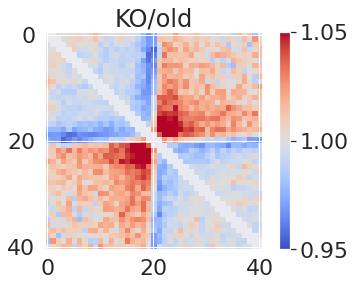

In [122]:
pairs = [['KO', 'WT'], ['old', 'young'], ['WT', 'young'], ['KO', 'old']]
for pair in pairs:
    divv = pup[pup.condition==pair[0]]['data'][0] / pup[pup.condition==pair[1]]['data'][0]
    plt.imshow(divv, interpolation='None', cmap='coolwarm', vmax=1.05, vmin=0.95)
    plt.title('%s/%s' % (pair[0], pair[1]))
    plt.colorbar()
    plt.show()

# TADs

### find TADs

In [132]:
#!pip install git+https://github.com/nvictus/lavaburst.git

#import lavaburst


In [124]:
#construct average TADs
pup = pd.DataFrame()
cond = [basename(c.filename).split('_')[1] for c in CLRS]
ids_10k = cooler.Cooler(DOWNSAMPLED_FOLDER_PATH + '/merged/combined_KO_down_10000.cool').bins()[:]
for k in border_dict.keys():
    clr = [c for c in CLRS if c.filename.__contains__(k)][0]
    name = splitext(basename(clr.filename))[0]
    #gather tad coordinates
    cond = [c for c in list(TADS.keys()) if c.__contains__(k.split('_')[0])][0]
    tads = TADS[cond]
    sites = pd.DataFrame()
    for chrom in tads.keys():
        tads[chrom]
        for t in tads[chrom]:
            st = ids_10k[ids_10k['chrom']==chrom].iloc[t[0]]['start']
            en = ids_10k[ids_10k['chrom']==chrom].iloc[t[1]]['end']
            sites = sites.append({'chrom':chrom, 'start':st, 'end':en}, ignore_index=True)
    sites['start'] = sites['start'].astype(int)
    sites['end'] = sites['end'].astype(int)
    #sites = sites.head(1)
    sites = sites[(sites['end'] - sites['start']) > 500_000]
    # Calculate expected interactions for chromosome arms
    expected = expected_cis(clr, view_df=mm10_arms, chunksize=1000000, nproc=18)
    #calculate mean interTADs
    cc = coolpup.CoordCreator(sites, resolution=RESOLUTION, 
                              features_format='bed', local=True, rescale_flank=0.5)
    pu = coolpup.PileUpper(clr, cc, 
                           expected=expected, 
                           rescale=True,
                           view_df=mm10_arms, ignore_diags=0)
    pup = pup.append(pu.pileupsWithControl(nproc=18))
pup['condition'] = [k.split('_')[1] for k in border_dict.keys()]
#pup['id'] = [basename(c.filename).split('_')[1] + '_' + basename(c.filename).split('_')[2].split('.')[0] for c in CLRS]

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Ignoring flank in favor of rescale_flank = 0.5
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Ignoring flank in favor of rescale_flank = 0.5
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Ignoring flank in favor of rescale_flank = 0.5
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Ignoring flank in favor of rescale_flank = 0.5


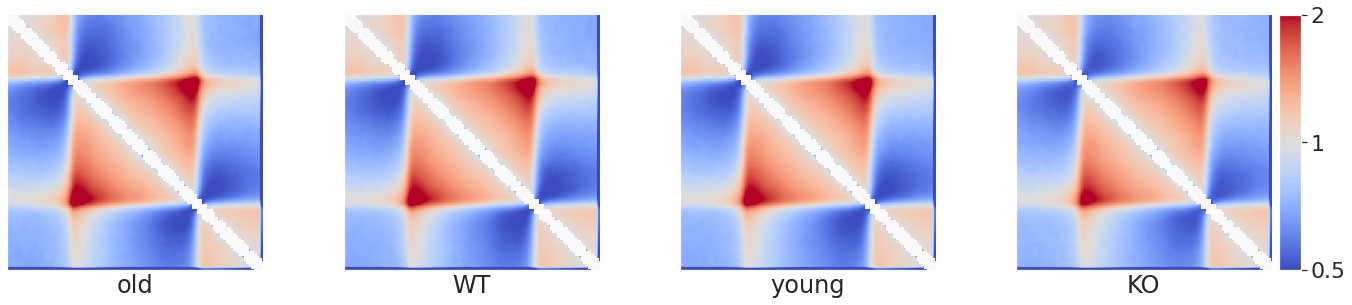

In [129]:
# plotpup.make_heatmap_grid(pup,
#                           rows='condition', #col_order=['--', '++'],
#                           cols='id',
#                           score=False, cmap='coolwarm', scale='log',
#                           sym=True, vmax=3, vmin=0.5,
#                           height=3)
plotpup.make_heatmap_grid(pup,
                          #rows='condition', #col_order=['--', '++'],
                          cols='condition',
                          score=False, cmap='coolwarm', scale='log',
                          sym=True, vmax=2,
                          height=5)

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


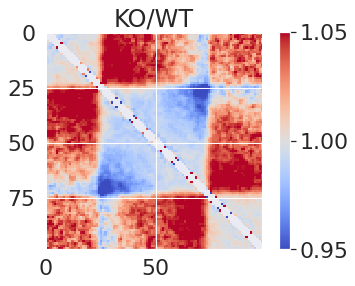

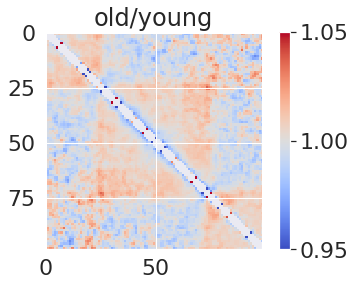

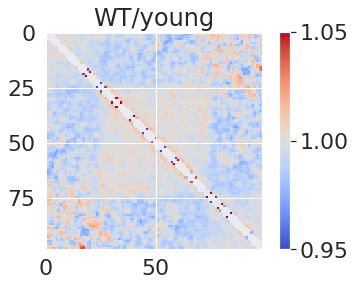

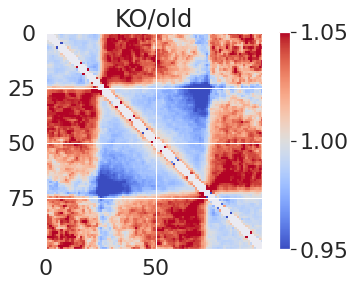

In [130]:
pairs = [['KO', 'WT'], ['old', 'young'], ['WT', 'young'], ['KO', 'old']]
for pair in pairs:
    divv = pup[pup.condition==pair[0]]['data'][0] / pup[pup.condition==pair[1]]['data'][0]
    plt.imshow(divv, interpolation='None', cmap='coolwarm', vmax=1.05, vmin=0.95)
    plt.title('%s/%s' % (pair[0], pair[1]))
    plt.colorbar()
    plt.show()

In [59]:
####plot average TADs by IS
# #construct average TADs
# pup = pd.DataFrame()
# cond = [basename(c.filename).split('_')[0] for c in CLRS]
# for k, v in border_dict.items():
#     clr = [c for c in CLRS if c.filename.__contains__(k)][0]
#     name = splitext(basename(clr.filename))[0]
#     #assumption: TADs are not intermittent
#     sites = IS.loc[v.tolist(),['chrom', 'start', 'end']].reset_index(drop=True)
#     sites['end'] = np.roll(sites['end'], -1)
#     sites = sites[:-1]
#     #sites = sites.head(1)
#     # Calculate expected interactions for chromosome arms
#     expected = expected_cis(clr, view_df=mm10_arms, chunksize=1000000, nproc=18)
#     #calculate mean interTADs
#     cc = coolpup.CoordCreator(sites, resolution=RESOLUTION, 
#                               features_format='bed', local=True, flank=1_000_000)
#     pu = coolpup.PileUpper(clr, cc, 
#                            #expected=expected, 
#                            rescale=True,
#                            view_df=mm10_arms, ignore_diags=0)
#     pup = pup.append(pu.pileupsWithControl(nproc=18))
# pup['condition'] = cond
# pup['id'] = [basename(c.filename).split('_')[1] + '_' + basename(c.filename).split('_')[2].split('.')[0] for c in CLRS]

In [60]:
# plotpup.make_heatmap_grid(pup,
#                           rows='condition', #col_order=['--', '++'],
#                           cols='id',
#                           score=False, cmap='coolwarm', scale='log',
#                           sym=True, vmax=0.01, vmin=0.001,
#                           height=3)

# Loops

In [91]:
import os
#Run loops finding
min_dist = 350_000
max_dist = 3_500_000
pearson = 0.45
for clr in tqdm(CLRS):    
    cool = clr.filename
    prefix = LOOP_PATH + '/' + splitext(basename(cool))[0]
    command = f"chromosight detect --threads 24 \
        --min-dist {min_dist} --max-dist {max_dist} --pearson {pearson} \
        {cool} {prefix}"
    os.system(command)


  0%|          | 0/4 [00:00<?, ?it/s]min_separation set to 5000 based on config file.
max_perc_undetected set to 50.0 based on config file.
max_perc_zero set to 10.0 based on config file.
Matrix already balanced, reusing weights
Preprocessing sub-matrices...
 [===-----------------] 14.3% chr4-chr4

Found 49386 / 54520 detectable bins


 [====================] 100.0% chrY-chrY[K[K
Detecting patterns...
 [--------------------] 0.0% Kernel: 0, Iteration: 0


Sub matrices extracted


 [====================] 100.0% Kernel: 0, Iteration: 0


Minimum pattern separation is : 1


2967 patterns detected
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_KO_down_50000.tsv
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_KO_down_50000.json
Saving pileup plots in /tank/projects/kriukov_chromatin/HIC/loops/combined_KO_down_50000.pdf
 25%|██▌       | 1/4 [00:12<00:37, 12.43s/it]min_separation set to 5000 based on config file.
max_perc_undetected set to 50.0 based on config file.
max_perc_zero set to 10.0 based on config file.
Matrix already balanced, reusing weights
Preprocessing sub-matrices...
 [===-----------------] 14.3% chr4-chr4

Found 49462 / 54520 detectable bins


 [====================] 100.0% chrY-chrY[K[K
Detecting patterns...
 [--------------------] 0.0% Kernel: 0, Iteration: 0


Sub matrices extracted


 [====================] 100.0% Kernel: 0, Iteration: 0


Minimum pattern separation is : 1


3068 patterns detected
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_WT_down_50000.tsv
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_WT_down_50000.json
Saving pileup plots in /tank/projects/kriukov_chromatin/HIC/loops/combined_WT_down_50000.pdf
 50%|█████     | 2/4 [00:25<00:25, 12.68s/it]min_separation set to 5000 based on config file.
max_perc_undetected set to 50.0 based on config file.
max_perc_zero set to 10.0 based on config file.
Matrix already balanced, reusing weights
Preprocessing sub-matrices...
 [===-----------------] 14.3% chr4-chr4

Found 49762 / 54520 detectable bins


 [====================] 100.0% chrY-chrY[K[K
Detecting patterns...
 [--------------------] 0.0% Kernel: 0, Iteration: 0


Sub matrices extracted


 [====================] 100.0% Kernel: 0, Iteration: 0


Minimum pattern separation is : 1


3099 patterns detected
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_old_down_50000.tsv
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_old_down_50000.json
Saving pileup plots in /tank/projects/kriukov_chromatin/HIC/loops/combined_old_down_50000.pdf
 75%|███████▌  | 3/4 [00:37<00:12, 12.54s/it]min_separation set to 5000 based on config file.
max_perc_undetected set to 50.0 based on config file.
max_perc_zero set to 10.0 based on config file.
Matrix already balanced, reusing weights
Preprocessing sub-matrices...
 [===-----------------] 14.3% chr4-chr4

Found 49449 / 54520 detectable bins


 [====================] 100.0% chrY-chrY[K[K
Detecting patterns...
 [--------------------] 0.0% Kernel: 0, Iteration: 0


Sub matrices extracted


 [====================] 100.0% Kernel: 0, Iteration: 0


Minimum pattern separation is : 1


3077 patterns detected
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_young_down_50000.tsv
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_young_down_50000.json
Saving pileup plots in /tank/projects/kriukov_chromatin/HIC/loops/combined_young_down_50000.pdf
100%|██████████| 4/4 [00:50<00:00, 12.59s/it]


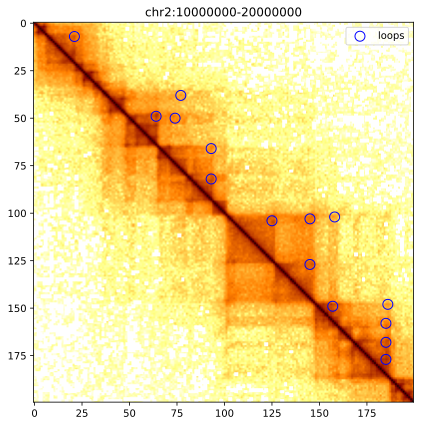

In [113]:
#look at them
%config InlineBackend.figure_format = 'svg'
import re
import json
import numpy as np
import pandas as pd
import cooler
import matplotlib.pyplot as plt
import chromosight.utils.detection as cud

loops = pd.read_csv('/tank/projects/kriukov_chromatin/HIC/loops/combined_KO_down_50000.tsv', sep='\t')
c = cooler.Cooler("/tank/projects/kriukov_chromatin/HIC/downsampled/merged/combined_KO_down_50000.cool")

def subset_region(df, region):
    """
    Given a pattern dataframe and UCSC region string, retrieve only patterns in that region.
    """
    # Split the region string at each occurence of - or : (yields 3 elements)
    chrom, start, end = re.split('[-:]', region)
    start, end = int(start), int(end)
    # Only keep patterns on the same chromosome as the region and
    # within the start-end interval
    subset = df.loc[
        (df.chrom1 == chrom) &
        (df.chrom2 == chrom) &
        (df.start1 >= start) &
        (df.start2 >= start) &
        (df.end1 < end) &
        (df.end2 < end), :
    ]
    return subset

# Select a region of interest

start = 10000000
#region = 'chr2:%d-%d' % (start, start + 3000000)
region = 'chr2:%d-%d' % (start, start + 10_000_000)
mat = c.matrix(sparse=False, balance=True).fetch(region)


loops_sub = subset_region(loops, region)
#borders_sub = subset_region(borders, region)
#hairpins_sub = subset_region(hairpins, region)

# Make genome-based bin numbers relative to the region
for df in [loops_sub]:#, borders_sub, hairpins_sub]:
    df.bin1 -= c.extent(region)[0]
    df.bin2 -= c.extent(region)[0]

%matplotlib inline
plt.figure(figsize=(7, 7))
plt.imshow(np.log10(mat), cmap='afmhot_r')
plt.title(region)
plt.scatter(loops_sub.bin2, loops_sub.bin1, edgecolors='blue', facecolors='none', label='loops', s=100)
#plt.scatter(borders_sub.bin2, borders_sub.bin1, c='lightblue', label='borders')
#plt.scatter(hairpins_sub.bin2, hairpins_sub.bin1, c='green', label='hairpins')
plt.legend()
plt.show()

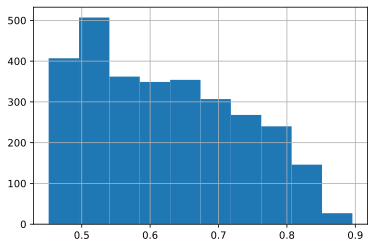

In [114]:
loops.score.hist()

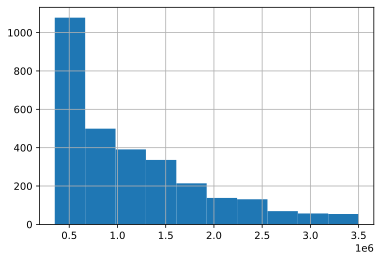

In [115]:
(loops['start2'] - loops['start1']).hist()

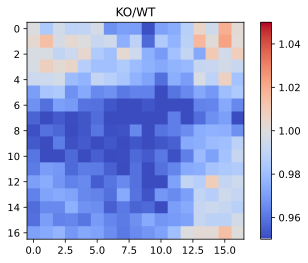

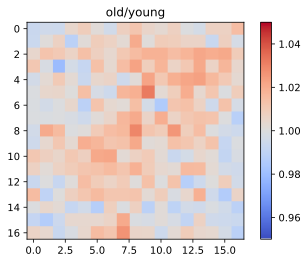

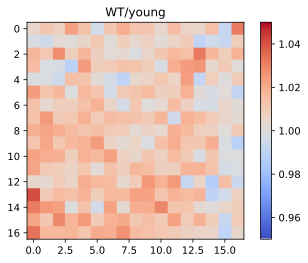

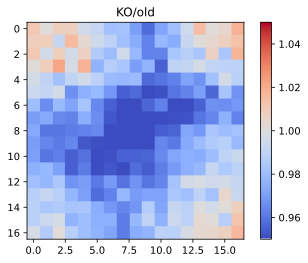

In [135]:
#compare between conditions
LOOPS_WIN_FILES = glob('/tank/projects/kriukov_chromatin/HIC/loops/*_50000.json')

average_loops = {}
for loop_file in LOOPS_WIN_FILES:
    # Load input json file into a dictionary
    loop_wins = json.load(open(loop_file, 'r'))
    # Note that keys are string, as required by the JSON format,
    # so we convert them to int() for convenience
    loop_wins = {int(i): np.array(w) for i, w in loop_wins.items()}
    # Make an empty 3D array of shape N_coords x height x width
    wins = np.zeros((len(loop_wins.items()), *loop_wins[0].shape))
    # Fill the 3D array with windows values
    for i, w in loop_wins.items(): wins[i] = w
    pileup = cud.pileup_patterns(wins)
    name = splitext(basename(loop_file))[0].split('_')[1]
    average_loops[name] = pileup

pairs = [['KO', 'WT'], ['old', 'young'], ['WT', 'young'], ['KO', 'old']]
for pair in pairs:
    divv = average_loops[pair[0]] / average_loops[pair[1]]
    plt.imshow(divv, cmap='coolwarm', vmax=1.05, vmin=0.95)
    plt.title('%s/%s' % (pair[0], pair[1]))
    plt.colorbar()
    plt.show()


# %matplotlib inline
# plt.figure(figsize=(4, 4))
# pileup = cud.pileup_patterns(wins)
# plt.title(basename(loop_file))
# plt.imshow(pileup, cmap='coolwarm', vmax=1.8, vmin=0)
# plt.show()

## ANOVA analysis

In [61]:
explore = ['WT', 'young', 'old']
mask = np.array([any([e in c for e in explore]) for c in IS.columns])

X = IS.drop(IS.columns[~mask], 1).T
X = X.dropna(axis=1)

y = [d.split('_')[0] for d in X.index] #0-for age; 1-for sex

types_dict = {'WT':'Y', 'young':'Y', 'old':'old', 'KO':'KO'}
y = [types_dict[t] for t in y]
print(y)

['Y', 'Y', 'Y', 'old', 'old', 'old', 'Y', 'Y', 'Y']


/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


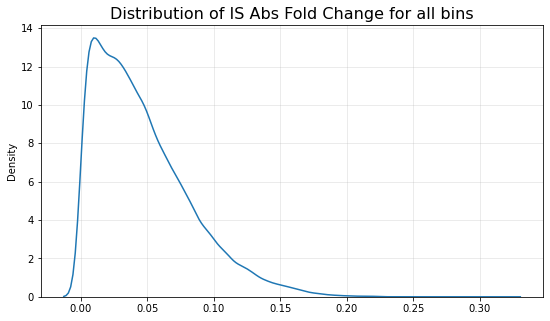

Total number of features: 42953
Number of p_values <= 0.050: 11162
Number of p_values after FDR correction: 4


,14282,14283,14284,35648
WT_female_2,0.444180,0.413791,0.379288,-0.265062
WT_female_3,0.434824,0.409935,0.391529,-0.276402
WT_male_1,0.431056,0.433262,0.423213,-0.249603
old_female_2,0.528548,0.539883,0.520195,-0.067546
old_female_3,0.516813,0.534430,0.513157,-0.106329
old_male_1,0.532389,0.524549,0.528388,-0.079973
young_female_2,0.429855,0.425943,0.393686,-0.286080
young_female_3,0.435138,0.423855,0.405221,-0.250814
young_male_1,0.414353,0.417796,0.401963,-0.292838


In [62]:
anova = ANOVA(X, y, 0.05)
anova.get_filter_distribution('FC')

a, b = anova.make_anova()
anova.get_passed_features()

100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


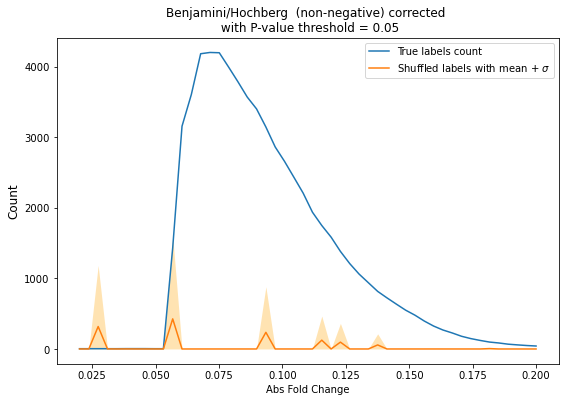

0.07142857142857144

In [63]:
anova.make_permutation_search('FC', interval=(0.02, 0.2), steps=50, N=15, **{'ddof':1})
anova.plot_permutation_results()
anova.get_best_criterion()

In [74]:
X_s, FDR, Pval = anova.get_passed_features_for_some_criterion(criterion=anova.get_best_criterion(), 
                                                        return_pvals=True)
P_adj_s_sorted = np.sort(FDR[1][FDR[0]])
X_s_sorted = X_s.iloc[:, np.argsort(FDR[1][FDR[0]])]

order = ['old', 'Y']
X_group = X_s_sorted.groupby(y).mean()
X_diff = X_group.loc[order[0]] - X_group.loc[order[1]]
#extract intervals and p_values, take top N bins
X_passed_intervals = IS.loc[X_s_sorted.columns][['chrom', 'start', 'end']]
X_passed_intervals['pval'] = Pval[FDR[0]]
X_passed_intervals['p_adj'] = P_adj_s_sorted
X_passed_intervals['FC'] = X_diff

print("Bins passed: %d" % X_passed_intervals.shape[0])

Bins passed: 4202


In [138]:
top = max(500, X_passed_intervals.shape[0])
X_top = X_passed_intervals.sort_values('pval').iloc[:top, :]

#intersection with genes
significant_genes = bins_to_genes_intersection(X_top[['chrom', 'start', 'end']], gn_code)

In [139]:
genesFC = significant_genes.merge(X_top, 
                    left_on=['Chromosome', 'Start_b', 'End_b'], 
                    right_on=['chrom', 'start', 'end'])[['chrom', 'Start', 'End', 'Start_b', 'End_b', 'Name', 'pval', 'FC']]

gmean = lambda x: np.exp(np.mean(np.log(x)))
agg = genesFC.groupby(['Name']).agg({'Start':'first','End':'first', 
                                     'Start_b':'first', 'End_b':'last', 
                                     'pval':gmean, 'FC':'mean'})
agg['p_adj'] = fdr_correction(agg['pval'], alpha=0.05, method='fdr_bh')[1]
agg['ES'] = -np.log10(agg['pval']) * agg['FC']

In [143]:
agg.to_csv('subdata/IS_results.csv')

In [136]:
#Assumptions:
# - Equal variances (sample sizes)
# - Normal distribution of population
# - Independence
EXPLORES = [['old', 'young'], ['KO', 'young'], ['WT', 'young'], ['KO', 'WT'], ['old', 'WT']]
gmean = lambda x: np.exp(np.mean(np.log(x)))

for explore in tqdm(EXPLORES):
    ### Data filtering
    fname = '::'.join(explore)
    mask = np.array([any([e in c for e in explore]) for c in IS.columns])
    X = IS.drop(IS.columns[~mask], 1).T
    X = X.dropna(axis=1)
    y = [d.split('_')[0] for d in X.index] #0-for age; 1-for sex
    
    ### ANOVA
    anova = ANOVA(X, y, 0.02)
    p, pcor = anova.make_anova()
    X_group = X.groupby(y).mean()
    X_diff = X_group.loc[explore[0]] - X_group.loc[explore[1]]
    #extract intervals and p_values, take top N bins
    X_passed_intervals = IS.loc[X.columns][['chrom', 'start', 'end']]
    X_passed_intervals['pval'] = p
    X_passed_intervals['FC'] = X_diff
   
    # #anova.make_permutation_search('FC', interval=(0.02, 0.2), steps=50, N=15, **{'ddof':1})
    # X_s, P_s = anova.get_passed_features_for_some_criterion(criterion=anova.get_best_criterion(), 
    #                                                         return_pvals=True)
    # #plot
    # #anova.plot_permutation_results(savename='Insulation/' + fname + '_FC.png')
    
    # P_adj_s_sorted = np.sort(P_s[1][P_s[0]])
    # X_s_sorted = X_s.iloc[:, np.argsort(P_s[1][P_s[0]])]
    
    #extract intervals and p_values, take top N bins
    # X_passed_intervals = IS_info.loc[X_s_sorted.columns][['chrom', 'start', 'end']]
    # X_passed_intervals['p_adj'] = P_adj_s_sorted
    # X_top = X_passed_intervals.iloc[:top, :]
    
    # #intersection with genes
    significant_genes = bins_to_genes_intersection(X_passed_intervals[['chrom', 'start', 'end']], gn_code)
    genesFC = significant_genes.merge(X_passed_intervals, 
                    left_on=['Chromosome', 'Start_b', 'End_b'], 
                    right_on=['chrom', 'start', 'end'])[['chrom', 'Start', 'End', 'Start_b', 'End_b', 'Name', 'pval', 'FC']]

    agg = genesFC.groupby(['Name']).agg({'Start':'first','End':'first', 
                                        'Start_b':'first', 'End_b':'last', 
                                        'pval':gmean, 'FC':'mean'})
    agg['p_adj'] = fdr_correction(agg['pval'], alpha=0.05, method='fdr_bh')[1]
    agg['ES'] = -np.log10(agg['pval']) * agg['FC'] * (-1) # corresponds to "openness"
    #break
    # print('Found %d genes in top %d bins' % (len(significant_genes), top))
    agg.to_csv('subdata/IS_results_%s.csv' % (fname))

  0%|          | 0/5 [00:00<?, ?it/s]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Total number of features: 42953
Number of p_values <= 0.020: 1917
Number of p_values after FDR correction: 0


 20%|██        | 1/5 [00:04<00:19,  4.94s/it]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Total number of features: 42953
Number of p_values <= 0.020: 7735
Number of p_values after FDR correction: 1


 40%|████      | 2/5 [00:09<00:14,  4.85s/it]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Total number of features: 42953
Number of p_values <= 0.020: 927
Number of p_values after FDR correction: 0


 60%|██████    | 3/5 [00:14<00:09,  4.87s/it]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Total number of features: 42953
Number of p_values <= 0.020: 10050
Number of p_values after FDR correction: 0


 80%|████████  | 4/5 [00:19<00:04,  4.84s/it]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Total number of features: 42953
Number of p_values <= 0.020: 3842
Number of p_values after FDR correction: 1


100%|██████████| 5/5 [00:24<00:00,  4.82s/it]


In [137]:
ko = pd.read_csv('subdata/IS_results_KO::young.csv', index_col=0)
wt = pd.read_csv('subdata/IS_results_WT::young.csv', index_col=0)
old = pd.read_csv('subdata/IS_results_old::young.csv', index_col=0)
kow = pd.read_csv('subdata/IS_results_KO::WT.csv', index_col=0)
oldw = pd.read_csv('subdata/IS_results_old::WT.csv', index_col=0)

In [138]:
ES = pd.DataFrame()
ES['KO'] = ko['ES']
ES['WT'] = wt['ES']
ES['old'] = old['ES']
ES['KO-W'] = kow['ES']
ES['old-W'] = oldw['ES']

ES.corr()

,KO,WT,old,KO-W,old-W
KO,1.000000,-0.045825,0.357672,0.803011,0.282115
WT,-0.045825,1.000000,-0.056689,-0.477473,-0.649553
old,0.357672,-0.056689,1.000000,0.329940,0.674201
KO-W,0.803011,-0.477473,0.329940,1.000000,0.599089
old-W,0.282115,-0.649553,0.674201,0.599089,1.000000


# ATAC-seq peaks

In [18]:
ATAC.columns[60:60]

Index(['KO_R1.mLb.clN.qval', 'KO_R2.mLb.clN.qval', 'KO_R3.mLb.clN.qval',
       'WT_R1.mLb.clN.qval', 'WT_R2.mLb.clN.qval', 'WT_R3.mLb.clN.qval',
       'old_R1.mLb.clN.qval', 'old_R2.mLb.clN.qval', 'old_R3.mLb.clN.qval',
       'young_R1.mLb.clN.qval', 'young_R2.mLb.clN.qval',
       'young_R3.mLb.clN.qval', 'KO_R1.mLb.clN.pval', 'KO_R2.mLb.clN.pval',
       'KO_R3.mLb.clN.pval', 'WT_R1.mLb.clN.pval', 'WT_R2.mLb.clN.pval',
       'WT_R3.mLb.clN.pval', 'old_R1.mLb.clN.pval', 'old_R2.mLb.clN.pval',
       'old_R3.mLb.clN.pval', 'young_R1.mLb.clN.pval', 'young_R2.mLb.clN.pval',
       'young_R3.mLb.clN.pval', 'KO_R1.mLb.clN.start', 'KO_R2.mLb.clN.start',
       'KO_R3.mLb.clN.start', 'WT_R1.mLb.clN.start', 'WT_R2.mLb.clN.start',
       'WT_R3.mLb.clN.start'],
      dtype='object')

In [25]:
peaks = ATAC[['chr', 'start', 'end', 'num_peaks', 'num_samples',
            'KO_R1.mLb.clN.bool', 'KO_R2.mLb.clN.bool', 'KO_R3.mLb.clN.bool',
            'WT_R1.mLb.clN.bool', 'WT_R2.mLb.clN.bool', 'WT_R3.mLb.clN.bool',
            'old_R1.mLb.clN.bool', 'old_R2.mLb.clN.bool', 'old_R3.mLb.clN.bool',
            'young_R1.mLb.clN.bool', 'young_R2.mLb.clN.bool', 'young_R3.mLb.clN.bool',
            'Distance to TSS','Gene Name']].copy()

In [27]:
peaks['length'] = ATAC['end'] - ATAC['start']
peaks['absTSS'] = np.abs(peaks['Distance to TSS'])

In [31]:
sum(peaks['absTSS'] < 500)

8383

In [19]:
ATAC[['chr', 'start', 'end', 'num_peaks', 'num_samples',
       'KO_R1.mLb.clN.fc', 'KO_R1.mLb.clN.pval', 'KO_R1.mLb.clN.qval', 'KO_R1.mLb.clN.start']]

,chr,start,end,num_peaks,num_samples,KO_R1.mLb.clN.fc,KO_R1.mLb.clN.pval,KO_R1.mLb.clN.qval,KO_R1.mLb.clN.start
0,1,3094953,3095639,7,7,NaN,NaN,NaN,NaN
1,1,3119552,3120933,12,12,4.26111,8.85153,5.84917,3119808
2,1,3195033,3195525,1,1,NaN,NaN,NaN,NaN
3,1,3292392,3293460,7,7,NaN,NaN,NaN,NaN
4,1,3297635,3298319,2,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
68289,Y,90800452,90800758,1,1,NaN,NaN,NaN,NaN
68290,Y,90804811,90805245,5,5,2.99465,6.58547,3.75818,90804845
68291,Y,90807111,90807842,3,3,NaN,NaN,NaN,NaN
68292,Y,90808445,90809289,3,3,NaN,NaN,NaN,NaN
